In [8]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold,RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score,roc_curve, roc_auc_score,auc
from scipy import stats

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
df = pd.read_csv('./data/df_full.csv',index_col='PassengerId')
df.head()

,Survived,Pclass,Age,SibSp,Parch,TicketFreq,Sex_female,Title_Mrs,Title_Ms,Title_Sir/Lady,...,CabinLetter_G,CabinLetter_T,CabinLetter_X,FamilySurvival_0.0,FamilySurvival_0.5,FamilySurvival_1.0,Embarked_0,Embarked_1,Embarked_2,FareBin
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.0,22.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0
2,1.0,1.0,38.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,11
3,1.0,3.0,26.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0,0,1,3
4,1.0,1.0,35.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,10
5,0.0,3.0,35.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0,0,1,3


In [3]:
tr = ~df['Survived'].isnull()

y = df[tr]['Survived'].to_numpy().astype(int)
X = df[tr].drop('Survived',1)

sub = df[~tr].drop('Survived',1)

num_cols = ['Age','SibSp','Parch','Pclass','TicketFreq','FareBin']
cat_cols = list(df.columns.difference(num_cols))

In [4]:
standard_sc = ColumnTransformer(transformers=[('num', StandardScaler(), num_cols)],remainder='passthrough')

pipe = Pipeline(steps=[
    ('sc', standard_sc),
    #('feat', PolynomialFeatures(interaction_only=True))
])

X_tr = pipe.fit_transform(X,y)
X_te = pipe.transform(sub)

In [5]:
def create_baseline():
    model = Sequential()
    model.add(Dense(9,input_dim=X_tr.shape[1], activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(Dense(9,activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model 

In [6]:
create_baseline().summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 234       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 290
Trainable params: 290
Non-trainable params: 0
_________________________________________________________________


In [11]:
clf = KerasClassifier(build_fn=create_baseline, epochs=200, batch_size=32, verbose=0,workers=4)
#cv = StratifiedShuffleSplit(n_splits=5, train_size=0.8, random_state=49)
#results = cross_val_score(clf, X_tr, y, cv=cv, n_jobs=-1,verbose=1)

In [202]:
f'CV accuracy: {results.mean():.3f} +- {results.std():.3f}'

'CV accuracy: 0.848 +- 0.027'

1
2
3
4
5
Mean acc: 0.8305 +- 0.0154


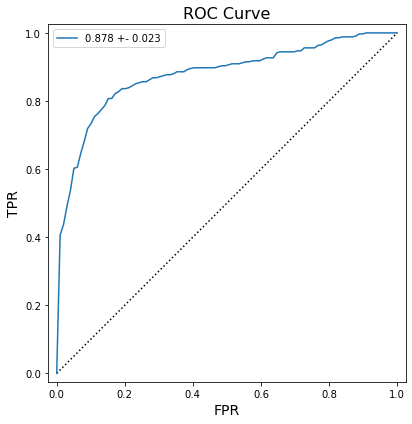

In [14]:
fpr = np.linspace(0,1,100)
mean_accs = []
        
tprs = []
aucs = []
acc = []
    
for j, (train, test) in enumerate(StratifiedKFold(5).split(X_tr,y)):
    print(j+1)
    fold_clf = clf.fit(X_tr[train],y[train],batch_size = 32, epochs = 200,verbose=0,shuffle=True,
         workers=4)
    acc.append(accuracy_score(y[test],clf.predict(X_tr[test])))
    fold_fpr, fold_tpr, _ = roc_curve(y[test], clf.predict_proba(X_tr[test])[:, 1])
    interp_tpr = np.interp(fpr,fold_fpr,fold_tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fold_fpr,fold_tpr))
    
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0,1],[0,1],'k:')

mean_acc = np.mean(acc)

std_acc = np.std(acc)
print(f'Mean acc: {mean_acc:.4f} +- {std_acc:.4f}')

mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(fpr, mean_tpr, 
        label=f"{mean_auc:.3f} +- {std_auc:.3f}",
        color=f'C0')

ax.set_title("ROC Curve",fontsize=16)
ax.set_xlabel("FPR",fontsize=14)
ax.set_ylabel("TPR",fontsize=14)
ax.set_xlim([-0.025,1.025])
ax.set_ylim([-0.025,1.025])
ax.set_aspect('equal')
ax.legend(loc="best")
fig.tight_layout();

In [162]:
clf.fit(X_tr, y, epochs=200, batch_size=32, verbose=0, workers=4)

pred = pd.DataFrame()
pred['PassengerId'] = sub.index
pred['Survived'] = (clf.predict(X_te) > 0.5).astype(int)
pred.to_csv('./submissions/keras_dropout.csv',index=False)

In [163]:
!kaggle competitions submit -c titanic -f ./submissions/keras_dropout.csv -m "keras dropout"

100%|██████████████████████████████████████| 2.77k/2.77k [00:01<00:00, 2.01kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster